# Main Code

In [1]:
# -------------------------------------------------------------------------------------
# 📊 TFT Time Series Forecasting Pipeline Configuration for a Target Stock
# -------------------------------------------------------------------------------------

# === 📦 Imports === #

# 🧪 Core Libraries
import os
import copy
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Time Series Modeling (Darts)
from darts import TimeSeries
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse, smape, mape, r2_score, rmsle, mse

# ⚙️ Machine Learning
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 📋 Utilities
from tabulate import tabulate

# ❗ Clean log output
warnings.filterwarnings("ignore")

# 📁 Custom Module
# DataGathering: Fetch stock & Yahoo macro data
from signal_sigma.data_gathering import DataGathering
# DataPreparator: Prepare dataset for modeling
from signal_sigma.data_preparator import DataPreparator
# FeatureEngineering: Generate technical indicators
from signal_sigma.feature_engineering import FeatureEngineering
# FredMacroProcessor: FED macroeconomic data + composites
from signal_sigma.fred_macro import FredMacroProcessor
# MarketMacroCompressor: Compress Yahoo macro indicators
from signal_sigma.market_macro_compressor import MarketMacroCompressor
# TemporalFeatureCombiner: Combine temporal features
from signal_sigma.temporal_feature_combiner import TemporalFeatureCombiner
# FeatureSelector: Select features for modeling
from signal_sigma.features_selection import ReducedFeatureSelector
# LossHistory: Track model loss history
from signal_sigma.loss_history import LossHistory

# === 🛠️ Configuration Parameters === #

# 📁 Data save path
path_stock = "../data/Stock_market_data"

# 📅 Time range
start_date = "2014-01-01"
end_date = "2025-05-09"

# 🎯 Target stock for forecasting
target_stock = "AAPL"

# ⏲️ Model training parameters
output_len = 15
n_epochs = 200

# 📈 Ticker list for model universe
tickers = [
    # Growth
    "AAPL",
    "MSFT",
    "GOOGL",
    "AMZN",
    "META",
    "NVDA",
    "TSLA",
    # Defensive
    "JPM",
    "V",
    "JNJ",
    "WMT",
    "PG",
    # Diversified
    "UNH",
    "DIS",
    "MA",
    "HD",
    "BAC",
    "PFE",
    "ADBE",
    "PEP",
]

# 📉 Macro indicators (Yahoo Finance-based)
# Volatility Index – fear gauge
macro_tickers = {"^VIX": "VIX_Index"}

# Step 1: Load Raw Dataset

In [2]:
# === 🔁 Step 1: Gather raw stock  === #
gatherer = DataGathering(
    stock_tickers=tickers,
    macro_tickers=macro_tickers,
    start_date="2014-01-01",
    end_date="2025-05-10",
)

raw_data_stock_yahoo = (
    gatherer.run()
)  # Fetch & structure historical OHLCV + Yahoo macro data
print("\n =======================================")
# === 📈 Step 2: FRED macroeconomic indicators (CPI, Fed Rate, Unemployment...) === #
processor = FredMacroProcessor(start_date=start_date, save_path=path_stock)
macro_FRED_df = (
    processor.run_pipeline()
)  # Fetch + construct 3 composite macroeconomic indicators
macro_FRED_df.to_csv(
    f"{path_stock}/tft_macro_FRED_df_{start_date}_{end_date}.csv",
    index=True,
    date_format="%Y-%m-%d",
)

ferd_feature_list = macro_FRED_df.columns.to_list()
print("\n =======================================")
# === 📊 Step 3: Yahoo macro compression (combine VIX, Gold, Bitcoin, etc.) === #
compressor = MarketMacroCompressor(
    start=start_date
)  # Use same start date for alignment
macro_Yahoo_df = (
    compressor.generate_macro_features()
)  # Output: 3 macro features from Yahoo indicators
macro_Yahoo_df.to_csv(
    f"{path_stock}/tft_macro_Yahoo_df_{start_date}_{end_date}.csv",
    index=True,
    date_format="%Y-%m-%d",
)
yahoo_feature_list = macro_Yahoo_df.columns.to_list()
print("\n =======================================")
# === 🔗 Step 4: Merge all datasets by date (left join) === #
raw_data_stock_economy = raw_data_stock_yahoo.merge(
    macro_FRED_df, left_index=True, right_index=True, how="left"
).merge(macro_Yahoo_df, left_index=True, right_index=True, how="left")
raw_data_stock_economy.ffill(inplace=True)
print("\n =======================================")
# Explanation:
# - All three DataFrames must have a datetime index
# - left join preserves all dates across all datasets
# - Missing values may exist — will be handled later

# === 🧬 Step 5: Optional — Save clean raw data for reuse or inspection === #
tft_raw_data_stock_economy = copy.deepcopy(
    raw_data_stock_economy
)  # Make a deep copy (safe backup)
tft_raw_data_stock_economy.to_csv(
    f"{path_stock}/tft_raw_data_stock_economy_{start_date}_{end_date}.csv",
    index=True,
    date_format="%Y-%m-%d",
)

print(
    f"✅ Saved full merged data to 'tft_raw_data_stock_economy_{start_date}_{end_date}.csv'"
)
print("\n =======================================")
print("[INFO] tft_raw_data_stock_economy summary:")
print("→ Shape      :", tft_raw_data_stock_economy.shape)
print("→ NaNs       :", tft_raw_data_stock_economy.isnull().sum().sum())
print(
    "→ Index Range:",
    tft_raw_data_stock_economy.index.min(),
    "→",
    tft_raw_data_stock_economy.index.max(),
)
print("→ Columns    :", list(tft_raw_data_stock_economy.columns), "...")
print("\n =======================================")

[INFO] Downloading stock tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'JPM', 'V', 'JNJ', 'WMT', 'PG', 'UNH', 'DIS', 'MA', 'HD', 'BAC', 'PFE', 'ADBE', 'PEP']
[✓] Downloaded: AAPL
[✓] Downloaded: MSFT
[✓] Downloaded: GOOGL
[✓] Downloaded: AMZN
[✓] Downloaded: META
[✓] Downloaded: NVDA
[✓] Downloaded: TSLA
[✓] Downloaded: JPM
[✓] Downloaded: V
[✓] Downloaded: JNJ
[✓] Downloaded: WMT
[✓] Downloaded: PG
[✓] Downloaded: UNH
[✓] Downloaded: DIS
[✓] Downloaded: MA
[✓] Downloaded: HD
[✓] Downloaded: BAC
[✓] Downloaded: PFE
[✓] Downloaded: ADBE
[✓] Downloaded: PEP
[INFO] Merging downloaded stock data...
[INFO] Final stock data shape: (2856, 100)
[INFO] Downloading macroeconomic & crypto data...
YF.download() has changed argument auto_adjust default to True
[✓] Downloaded: VIX_Index
[INFO] Final macro data shape: (2856, 1)
[INFO] Merging stock and macro data...
[✓] Final dataset saved to: ../data/Stock_market_data/clean_stock_data_with_time_index.csv
[INFO] Final merged shap

[*********************100%***********************]  18 of 18 completed


🧪 Preprocessing: Filling missing values...
✅ Macro composite features created.


✅ Saved full merged data to 'tft_raw_data_stock_economy_2014-01-01_2025-05-09.csv'

[INFO] tft_raw_data_stock_economy summary:
→ Shape      : (2856, 107)
→ NaNs       : 0
→ Index Range: 2014-01-02 00:00:00 → 2025-05-09 00:00:00
→ Columns    : ['open_AAPL', 'high_AAPL', 'low_AAPL', 'close_AAPL', 'volume_AAPL', 'open_MSFT', 'high_MSFT', 'low_MSFT', 'close_MSFT', 'volume_MSFT', 'open_GOOGL', 'high_GOOGL', 'low_GOOGL', 'close_GOOGL', 'volume_GOOGL', 'open_AMZN', 'high_AMZN', 'low_AMZN', 'close_AMZN', 'volume_AMZN', 'open_META', 'high_META', 'low_META', 'close_META', 'volume_META', 'open_NVDA', 'high_NVDA', 'low_NVDA', 'close_NVDA', 'volume_NVDA', 'open_TSLA', 'high_TSLA', 'low_TSLA', 'close_TSLA', 'volume_TSLA', 'open_JPM', 'high_JPM', 'low_JPM', 'close_JPM', 'volume_JPM', 'open_V', 'high_V', 'low_V', 'close_V', 'volume_V', 'open_JNJ', 'high_JNJ', 'low_JNJ', 'close_JNJ', 'volume_JNJ', 'open_WMT', 'high_WMT', '

# Step 2-1: Prepare modeling dataset (Featured)

In [3]:
# Step 2: Prepare modeling dataset directly from  CSV file or from the output of last cell
tft_raw_data_stock_economy = pd.read_csv(
    f"{path_stock}/tft_raw_data_stock_economy_{start_date}_{end_date}.csv",
    parse_dates=["date"],
    index_col="date",
).sort_index()

tft_macro_Yahoo_df = pd.read_csv(
    f"{path_stock}/tft_macro_Yahoo_df_{start_date}_{end_date}.csv",
    index_col=0,
    parse_dates=True,
).sort_index()

tft_macro_FRED_df = pd.read_csv(
    f"{path_stock}/tft_macro_FRED_df_{start_date}_{end_date}.csv",
    index_col=0,
    parse_dates=True,
).sort_index()


# === 📈 Step 2: FRED macroeconomic indicators (CPI, Fed Rate, Unemployment...) === #
ferd_feature_list = tft_macro_FRED_df.columns.to_list()
print("\n =======================================")
# === 📊 Step 3: Yahoo macro compression (combine VIX, Gold, Bitcoin, etc.) === #
yahoo_feature_list = tft_macro_Yahoo_df.columns.to_list()
print("\n =======================================")

preparator = DataPreparator(
    data=tft_raw_data_stock_economy,
    target_stock=target_stock,
    stock_list=tickers,
    time_cutoff="2017-01-01",  # please not change this value
)
model_dataset = preparator.prepare()
model_dataset.to_csv(
    f"{path_stock}/tft_model_dataset_feature_{end_date}.csv",
    index=True,
    date_format="%Y-%m-%d",
)
print(
    f" Saved full Featured Engineering  'tft_model_dataset_feature_{end_date}.csv.csv'"
)

model_dataset_copy = copy.deepcopy(model_dataset)  # Backup copy
print("\n [INFO] Loading finished.")



[INFO] Using provided DataFrame as source data.
[INFO] Preparing target stock: AAPL
[INFO] Calculating total average daily investment across all tracked stocks...
[INFO] Analyzing investment trend features for AAPL only...
  ↳ Features added for AAPL: Δ7d, %Δ7d, Δ30d, %Δ30d, mean, std, z-score
[INFO] Dropping raw OHLCV and investment columns (except target)...
[INFO] Generating technical indicators and engineered features...
[TRACE] --- class FeatureEngineering: Reindexing to NYSE trading calendar...
[TRACE] --- class FeatureEngineering: Starting full feature generation...
[TRACE] --- class FeatureEngineering: add_trend_indicators
[TRACE] --- class FeatureEngineering: add_momentum_indicators
[TRACE] --- class FeatureEngineering: calculate_stochastic
[TRACE] --- class FeatureEngineering: add_volatility_indicators
[TRACE] --- class FeatureEngineering: add_volume_indicators
[TRACE] --- class FeatureEngineering: add_seasonal_features
[TRACE] --- class FeatureEngineering: add_return_featu

# Combine temporally grouped features

In [4]:
# 3 Combine Features from FERD
ferd_feature_list
print(f" Number of Combine Features from FERD", len(ferd_feature_list))
print(f" Features from FERD", ferd_feature_list)
print("\n =======================================")

yahoo_feature_list
print(f" Number of Combine Features from Yahoo", len(yahoo_feature_list))
print(f" Features from Yahoo", yahoo_feature_list)
print("\n =======================================")


# Combine temporally grouped features
combiner = TemporalFeatureCombiner(model_dataset)
model_dataset_combined = combiner.combine()

model_dataset_combined_copy = copy.deepcopy(model_dataset_combined)  # Backup copy

combine_col_all = model_dataset_combined.columns.to_list()

print(
    f" Number of all avaialbe in model_dataset_combined (Additional TI) ",
    len(combine_col_all),
)
print(f" all avaialbe in model_dataset_combined (Additional TI)", combine_col_all)
print("\n =======================================")


# Keep only the combined features + 'target'
seasonal_cols = [
    col for col in model_dataset_combined.columns if col.startswith("season_")
]
print("\n [INFO] seasonal_cols :", seasonal_cols)
print(f" Number of seasonal_cols ", len(seasonal_cols))
print("\n =======================================")


original_cols = set(model_dataset.columns) - {"target"}
combined_features = [
    col for col in model_dataset_combined.columns if col not in original_cols
]
print("\n [INFO] only Additional Combine Features based on TI :", combined_features)
print(f" Number of Additional Combine Features based on TI", len(combined_features))
print("\n =======================================")

 Number of Combine Features from FERD 3
 Features from FERD ['FRED_inflation_monetary_pressure', 'FRED_labor_econ_activity', 'FRED_consumer_spending_sentiment']

 Number of Combine Features from Yahoo 3
 Features from Yahoo ['Yahoo_mcro_market_stress', 'Yahoo_mcro_growth_innovation_sentiment', 'Yahoo_mcro_real_asset_confidence']

 Number of all avaialbe in model_dataset_combined (Additional TI)  129
 all avaialbe in model_dataset_combined (Additional TI) ['target', 'trend_sma_7', 'trend_sma_100', 'trend_sma_300', 'trend_ema_50', 'trend_ema_100', 'trend_ema_250', 'trend_ema_1000', 'trend_macd', 'trend_macd_signal', 'momentum_rsi_3', 'momentum_rsi_75', 'momentum_rsi_150', 'momentum_diff_7', 'momentum_roc_7', 'momentum_diff_50', 'momentum_roc_50', 'momentum_diff_100', 'momentum_roc_100', 'momentum_stoch_k', 'momentum_stoch_d', 'volatility_atr_3', 'volatility_donchian_high_3', 'volatility_donchian_low_3', 'volatility_atr_14', 'volatility_donchian_high_14', 'volatility_donchian_low_14', 'vo

# Manual Feature selectio  

In [5]:
# Combine all features into one list - select the feature you want for the training
top_5_feature_ai_offer = [
    "momentum_rsi_75",
    "trend_macd",
    "return_5d",
    "price_investment_trend_7d",
    "volatility_atr_14",
]


low_dimension_feature = (
    top_5_feature_ai_offer + combined_features + yahoo_feature_list + ferd_feature_list
)  # + seasonal_cols  #if needed
# Remove duplicates (preserving order)
low_dimension_feature = list(dict.fromkeys(low_dimension_feature))
print("\n [INFO] low_dimension_feature :", low_dimension_feature)
print(f" Number of Features based low_dimension_feature", len(low_dimension_feature))
print("\n =======================================")

model_dataset_low_dimension = model_dataset_combined[low_dimension_feature]

model_dataset.to_csv(
    f"{path_stock}/model_dataset_{end_date}.csv", index=True, date_format="%Y-%m-%d"
)
print(f" Saved full Featured Engineering  'model_dataset_{end_date}.csv.csv'")

model_dataset_low_dimension.to_csv(
    f"{path_stock}/model_dataset_low_dimension_{end_date}.csv",
    index=True,
    date_format="%Y-%m-%d",
)
print(
    f" Saved full Featured Engineering  'model_dataset_low_dimension_{end_date}.csv.csv'"
)

print("\n =======================================")
print("[INFO] model_dataset_combined summary:")
print("→ Shape      :", model_dataset_combined.shape)
print("→ NaNs       :", model_dataset_combined.isnull().sum().sum())
print(
    "→ Index Range:",
    model_dataset_combined.index.min(),
    "→",
    model_dataset_combined.index.max(),
)
print("→ Columns    :", list(model_dataset_combined.columns), "...")
print("\n =======================================")
print("[INFO] model_dataset_low_dimension summary:")
print("→ Shape      :", model_dataset_low_dimension.shape)
print("→ NaNs       :", model_dataset_low_dimension.isnull().sum().sum())
print(
    "→ Index Range:",
    model_dataset_low_dimension.index.min(),
    "→",
    model_dataset_low_dimension.index.max(),
)
print("→ Columns    :", list(model_dataset_low_dimension.columns), "...")
print(
    "\n[INFO] ✅ Ready: Reduced feature dataset with only combined features + target."
)


 [INFO] low_dimension_feature : ['momentum_rsi_75', 'trend_macd', 'return_5d', 'price_investment_trend_7d', 'volatility_atr_14', 'target', 'TI_short_trend_signal', 'TI_short_volume_pressure', 'TI_short_lag_movement', 'TI_medium_trend_consistency', 'TI_medium_volume_pressure', 'TI_medium_lag_movement', 'TI_long_term_trend_strength', 'TI_long_donchian_channel_width', 'TI_long_lag_signal', 'Yahoo_mcro_market_stress', 'Yahoo_mcro_growth_innovation_sentiment', 'Yahoo_mcro_real_asset_confidence', 'FRED_inflation_monetary_pressure', 'FRED_labor_econ_activity', 'FRED_consumer_spending_sentiment']
 Number of Features based low_dimension_feature 21

 Saved full Featured Engineering  'model_dataset_2025-05-09.csv.csv'
 Saved full Featured Engineering  'model_dataset_low_dimension_2025-05-09.csv.csv'

[INFO] model_dataset_combined summary:
→ Shape      : (2100, 129)
→ NaNs       : 0
→ Index Range: 2017-01-03 00:00:00 → 2025-05-09 00:00:00
→ Columns    : ['target', 'trend_sma_7', 'trend_sma_100', 

# 🔄 Step 2-2: Automatic Features Slection baed on Mutual Information , XGBOOST and VIF 


search for the top features in :  Index(['target', 'trend_sma_7', 'trend_sma_100', 'trend_sma_300',
       'trend_ema_50', 'trend_ema_100', 'trend_ema_250', 'trend_ema_1000',
       'trend_macd', 'trend_macd_signal',
       ...
       'ratio_daily_invest_AAPL_zscore', 'TI_short_trend_signal',
       'TI_short_volume_pressure', 'TI_short_lag_movement',
       'TI_medium_trend_consistency', 'TI_medium_volume_pressure',
       'TI_medium_lag_movement', 'TI_long_term_trend_strength',
       'TI_long_donchian_channel_width', 'TI_long_lag_signal'],
      dtype='object', length=116)



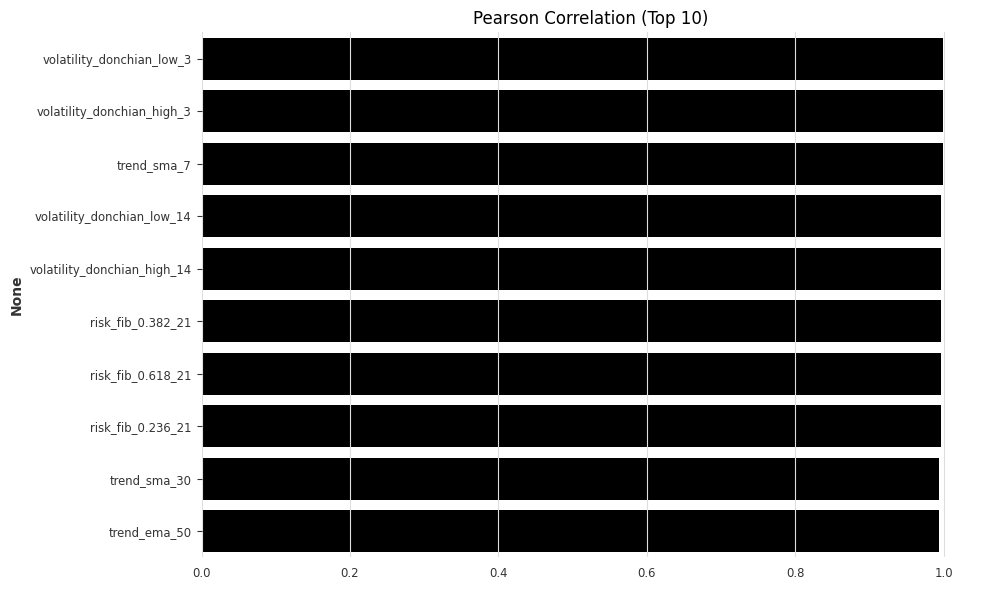

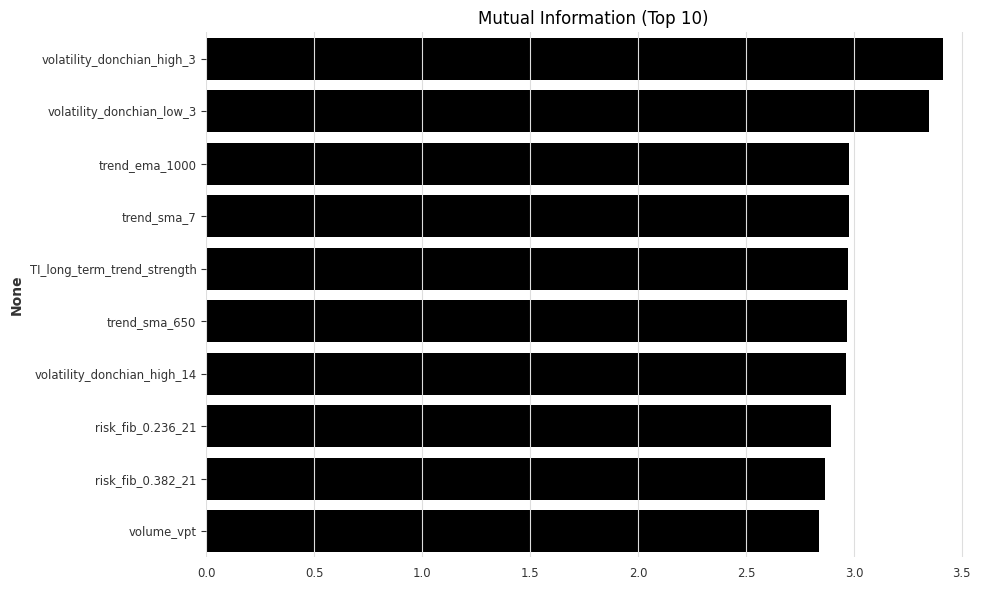

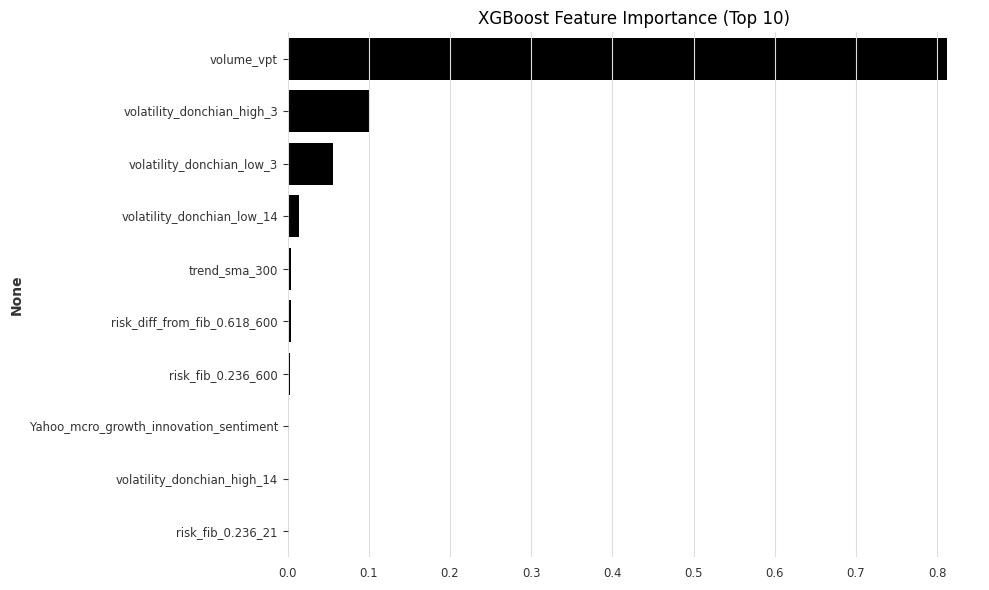

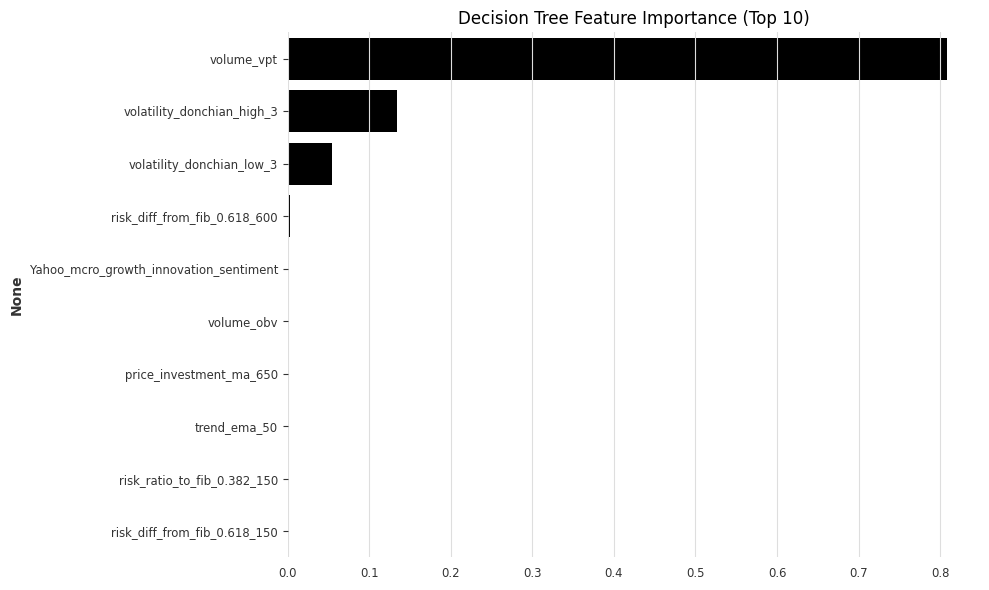

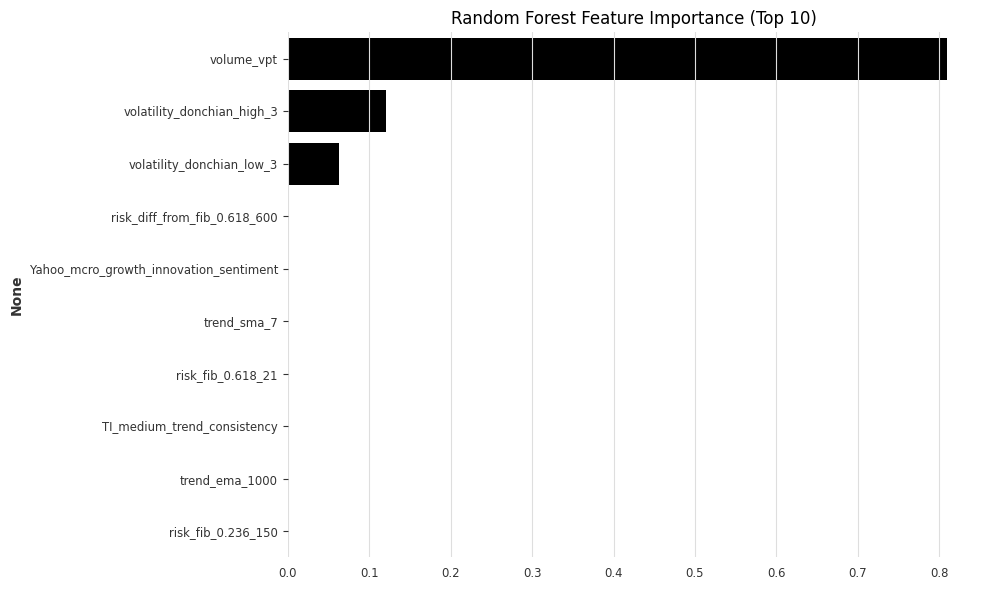

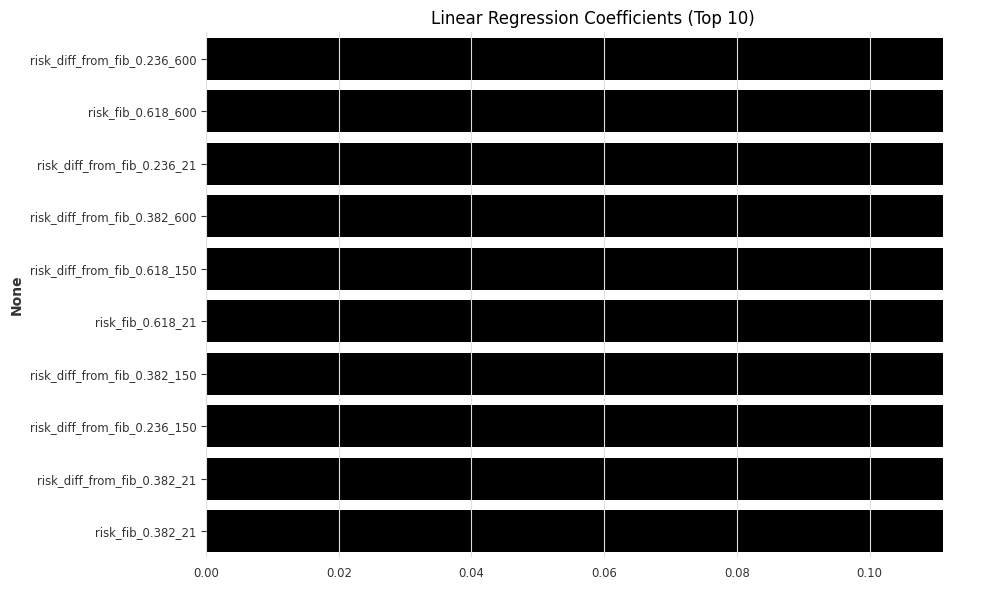

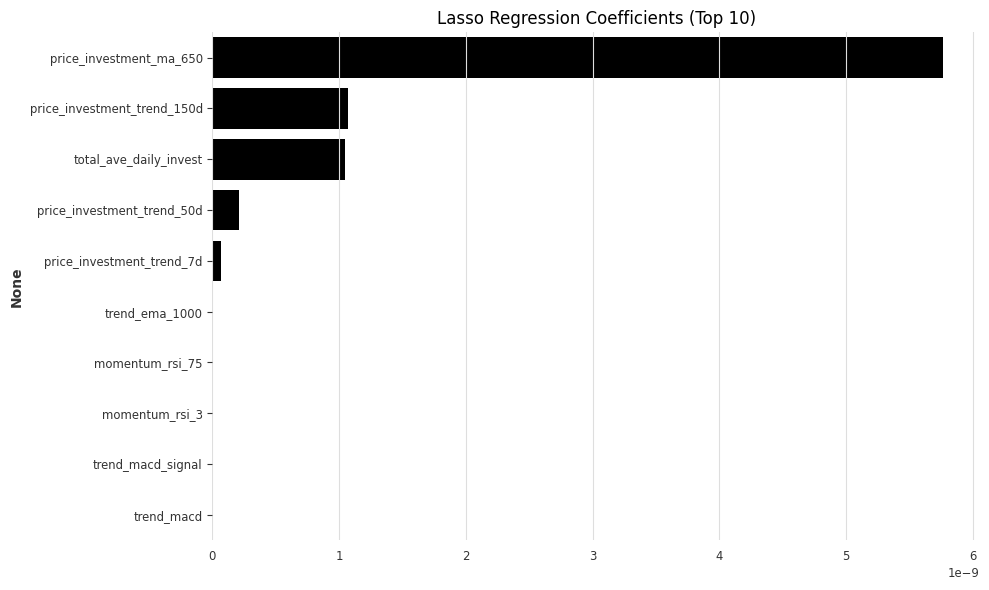

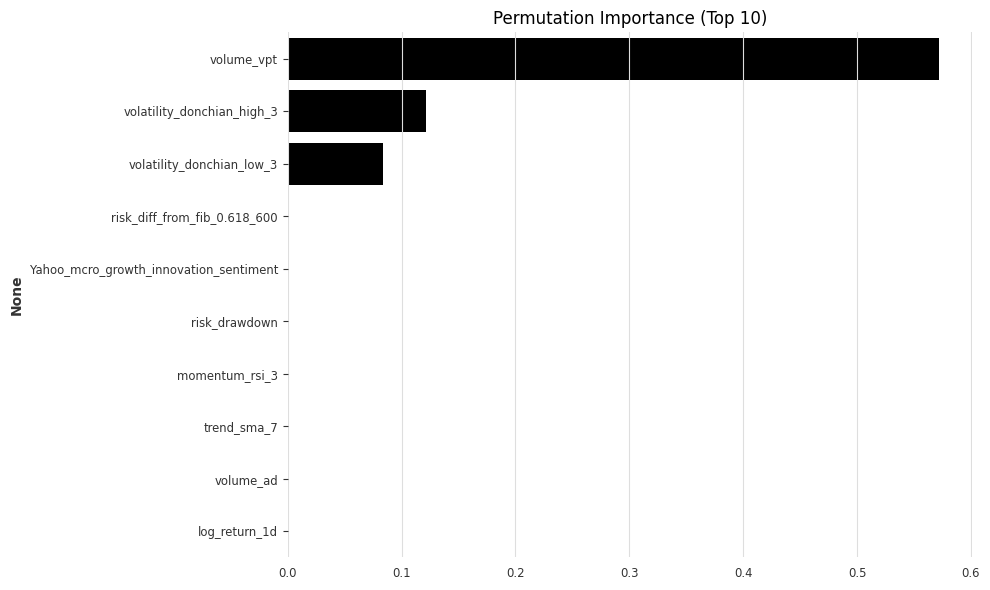


✅ Final Selected Features (Deduplicated from all models): 42
['volatility_donchian_low_3', 'volatility_donchian_high_3', 'trend_sma_7', 'volatility_donchian_low_14', 'volatility_donchian_high_14', 'risk_fib_0.382_21', 'risk_fib_0.618_21', 'risk_fib_0.236_21', 'trend_sma_30', 'trend_ema_50', 'trend_ema_1000', 'TI_long_term_trend_strength', 'trend_sma_650', 'volume_vpt', 'trend_sma_300', 'risk_diff_from_fib_0.618_600', 'risk_fib_0.236_600', 'Yahoo_mcro_growth_innovation_sentiment', 'volume_obv', 'price_investment_ma_650', 'trend_sma_100', 'TI_medium_trend_consistency', 'risk_fib_0.236_150', 'risk_diff_from_fib_0.236_600', 'risk_fib_0.618_600', 'risk_diff_from_fib_0.236_21', 'risk_diff_from_fib_0.382_600', 'risk_diff_from_fib_0.618_150', 'risk_diff_from_fib_0.382_150', 'risk_diff_from_fib_0.236_150', 'risk_diff_from_fib_0.382_21', 'price_investment_trend_150d', 'total_ave_daily_invest', 'price_investment_trend_50d', 'price_investment_trend_7d', 'price_investment_deviation_30d', 'price_in

In [6]:
col_entry_feature_selection = [
    col for col in model_dataset_combined.columns if col not in seasonal_cols
]
col_entry_feature_selection = list(dict.fromkeys(col_entry_feature_selection))
print("\n =======================================")
print(
    "search for the top features in : ",
    model_dataset_combined[col_entry_feature_selection].columns,
)
print("\n =======================================")
# model_dataset_low_dimension
selector = ReducedFeatureSelector(
    data=model_dataset_combined[col_entry_feature_selection],
    target_col="target",
    top_n=10,
)
automatic_selected_features, model_scores = selector.select_features()

print("\n[INFO] Final Selected Features:")
print(automatic_selected_features)

# 🔄 Step 2-3: Prepre the Columns for Datasets Model

In [7]:
# Combine with seasonal columns and exclude 'target' correctly

# model_dataset_low_dimension = model_dataset_combined[low_dimension_feature] # manual selection

# model_dataset_combined[low_dimension_feature]

# automatic_selected_features = [['volatility_donchian_low_3', 'volatility_donchian_high_3']+ ['target']]

# ['target']

# feature selection based ML (RF, XGBOOST, CORR())
model_dataset_low_dimension = model_dataset_combined[
    automatic_selected_features + ["target"]
]

model_df = model_dataset_low_dimension
features_list_model = [
    col for col in model_dataset_low_dimension.columns if col != "target"
]
print("\n[INFO] numbers of features_list for model:", len(features_list_model))
print("\n[INFO] features_list for model:", features_list_model)


[INFO] numbers of features_list for model: 42

[INFO] features_list for model: ['volatility_donchian_low_3', 'volatility_donchian_high_3', 'trend_sma_7', 'volatility_donchian_low_14', 'volatility_donchian_high_14', 'risk_fib_0.382_21', 'risk_fib_0.618_21', 'risk_fib_0.236_21', 'trend_sma_30', 'trend_ema_50', 'trend_ema_1000', 'TI_long_term_trend_strength', 'trend_sma_650', 'volume_vpt', 'trend_sma_300', 'risk_diff_from_fib_0.618_600', 'risk_fib_0.236_600', 'Yahoo_mcro_growth_innovation_sentiment', 'volume_obv', 'price_investment_ma_650', 'trend_sma_100', 'TI_medium_trend_consistency', 'risk_fib_0.236_150', 'risk_diff_from_fib_0.236_600', 'risk_fib_0.618_600', 'risk_diff_from_fib_0.236_21', 'risk_diff_from_fib_0.382_600', 'risk_diff_from_fib_0.618_150', 'risk_diff_from_fib_0.382_150', 'risk_diff_from_fib_0.236_150', 'risk_diff_from_fib_0.382_21', 'price_investment_trend_150d', 'total_ave_daily_invest', 'price_investment_trend_50d', 'price_investment_trend_7d', 'price_investment_deviati

# Step 2-4:Reindexing to daily frequency

In [8]:
# ------------------------------------------------------------------------------
# 🧾 Step 2: Inspect & Standardize Time Index (Reindexing to Daily Frequency)
# ------------------------------------------------------------------------------
# if you want to use the combine neeed to use below othervise disable them

print("\n[INFO] Loaded model_dataset info ---before--- Reindexing to daily frequency")

# Show current dataset shape
print("[INFO] Loaded model_dataset shaped: ", model_df.shape)

# Count total missing values (NaNs) before interpolation
print("[INFO] Loaded model_dataset NaN: ", model_df.isnull().sum().sum())

# Print dataset type to confirm it's a DataFrame
print("[INFO] Loaded model_dataset type: ", type(model_df))

# Show time index range (first and last date)
print(
    "[INFO] Loaded model_dataset index:",
    model_df.index.min(),
    "--- to ---",
    model_df.index.max(),
)

# ------------------------------------------------------------------------------
print("\n[INFO] Loaded model_dataset info ---After---  Reindexing to daily frequency")

# ✅ Generate full date range from min to max using daily frequency
full_index = pd.date_range(
    start=model_df.index.min(), end=model_df.index.max(), freq="D"
)

# 🧠 Check if the time index is irregular or not sorted
if model_df.index.inferred_freq is None or not model_df.index.is_monotonic_increasing:
    print("[INFO] Reindexing to daily frequency and interpolating missing values...")

    # 📅 Reindex the DataFrame to ensure a daily time index (even if days were missing)
    model_df = model_df.reindex(full_index)

    # 🔧 Fill gaps using linear interpolation in both directions (forward & backward)
    model_df.interpolate(method="linear", limit_direction="both", inplace=True)

# ------------------------------------------------------------------------------
# ✅ Show updated dataset info after reindexing and interpolation

print("[INFO] Loaded model_dataset shaped: ", model_dataset.shape)
print("[INFO] Loaded model_dataset NaN: ", model_dataset.isnull().sum().sum())
print("[INFO] Loaded model_dataset type: ", type(model_dataset))
print(
    "[INFO] Loaded model_dataset index:",
    model_dataset.index.min(),
    "--- to ---",
    model_dataset.index.max(),
)

print("\n[INFO] Finished Reindexing to daily frequency")


[INFO] Loaded model_dataset info ---before--- Reindexing to daily frequency
[INFO] Loaded model_dataset shaped:  (2100, 43)
[INFO] Loaded model_dataset NaN:  0
[INFO] Loaded model_dataset type:  <class 'pandas.core.frame.DataFrame'>
[INFO] Loaded model_dataset index: 2017-01-03 00:00:00 --- to --- 2025-05-09 00:00:00

[INFO] Loaded model_dataset info ---After---  Reindexing to daily frequency
[INFO] Reindexing to daily frequency and interpolating missing values...
[INFO] Loaded model_dataset shaped:  (2100, 120)
[INFO] Loaded model_dataset NaN:  0
[INFO] Loaded model_dataset type:  <class 'pandas.core.frame.DataFrame'>
[INFO] Loaded model_dataset index: 2017-01-03 00:00:00 --- to --- 2025-05-09 00:00:00

[INFO] Finished Reindexing to daily frequency


# 🔁 Step 3: Convert to Darts TimeSeries format 


In [9]:
# ---------------------------------------------
# 🎯 Step 3-1: Convert Target Column to Darts TimeSeries
# ---------------------------------------------

from darts import TimeSeries  # ⏳ Darts TimeSeries object for forecasting
import numpy as np  # 🧮 NumPy for handling NaN and array stats

print("\n[INFO] Step 3: Convert to Darts TimeSeries format\n")

# # XXX: On Apple Silicon, Darts may require float32 instead of float64
# # to avoid issues with PyTorch. This is a workaround for compatibility.
# cols = model_df.select_dtypes(include=["float64"]).columns
# model_df[cols] = model_df[cols].astype(np.float32)
# # # Or alternatively, you can set the device to CPU
# # import torch
# # torch_device = torch.device("cpu")

# ✅ Extract target column as a DataFrame (not Series) to retain column name
raw_target_df = model_df[["target"]]

# ✅ Convert to Darts TimeSeries:
# - value_cols="target" tells Darts which column contains values
# - freq="D" sets the expected time step to daily
# - fill_missing_dates=True fills missing dates in the index to ensure regular spacing
raw_target = TimeSeries.from_dataframe(
    raw_target_df, value_cols="target", freq="D", fill_missing_dates=True
)

# 📋 Log target series info
print("[INFO] raw_target")
print(f"[INFO]   • Type        : {type(raw_target)}")  # Confirm TimeSeries object
print(f"[INFO]   • Length      : {len(raw_target)}")  # Total time steps
print(f"[INFO]   • Shape       : {raw_target.shape}")  # Shape: (time, components, 1)
print(
    f"[INFO]   • Frequency   : {raw_target.freq_str}"
)  # Frequency string (should be 'D')
print(
    f"[INFO]   • NaNs        : {np.isnan(raw_target.values()).sum()}"
)  # Total NaNs in the time series
print(
    f"[INFO]   • Time Range  : {raw_target.time_index.min()} → {raw_target.time_index.max()}"
)  # Date range

print("\n")

# ------------------------------------------------
# 🎯 Step 3-2:Convert Feature Columns to Darts TimeSeries
# ------------------------------------------------

# ✅ Extract multiple feature columns for covariates
raw_covariates_df = model_df[features_list_model]

# ✅ Convert multivariate features to TimeSeries:
# - value_cols=features_list_model ensures all selected columns are included
# - fill_missing_dates ensures continuity
raw_covariates = TimeSeries.from_dataframe(
    raw_covariates_df, value_cols=features_list_model, freq="D", fill_missing_dates=True
)

# 📋 Log covariates series info
print("[INFO] raw_covariates")
print(f"[INFO]   • Type        : {type(raw_covariates)}")  # Confirm TimeSeries object
print(f"[INFO]   • Length      : {len(raw_covariates)}")  # Total time steps
print(f"[INFO]   • Shape       : {raw_covariates.shape}")  # (time, features, 1)
print(f"[INFO]   • Frequency   : {raw_covariates.freq_str}")  # 'D' for daily
print(
    f"[INFO]   • NaNs        : {np.isnan(raw_covariates.values()).sum()}"
)  # Total missing values
print(
    f"[INFO]   • Time Range  : {raw_covariates.time_index.min()} → {raw_covariates.time_index.max()}"
)  # Time span


[INFO] Step 3: Convert to Darts TimeSeries format

[INFO] raw_target
[INFO]   • Type        : <class 'darts.timeseries.TimeSeries'>
[INFO]   • Length      : 3049
[INFO]   • Shape       : (3049, 1, 1)
[INFO]   • Frequency   : D
[INFO]   • NaNs        : 0
[INFO]   • Time Range  : 2017-01-03 00:00:00 → 2025-05-09 00:00:00


[INFO] raw_covariates
[INFO]   • Type        : <class 'darts.timeseries.TimeSeries'>
[INFO]   • Length      : 3049
[INFO]   • Shape       : (3049, 42, 1)
[INFO]   • Frequency   : D
[INFO]   • NaNs        : 0
[INFO]   • Time Range  : 2017-01-03 00:00:00 → 2025-05-09 00:00:00


# Step 3-3: Sanity Check – Are raw_target and raw_covariates aligned?

In [10]:
# ------------------------------------------------------------------------
# ✅ Step 3-3: Sanity Check – Are raw_target and raw_covariates aligned?
# ------------------------------------------------------------------------

aligned = True

# 1. Check if time ranges are equal
if (
    raw_target.start_time() != raw_covariates.start_time()
    or raw_target.end_time() != raw_covariates.end_time()
):
    print("[WARNING] ⚠️ Time range mismatch between target and covariates!")
    print(f"  → raw_target    : {raw_target.start_time()} → {raw_target.end_time()}")
    print(
        f"  → raw_covariates: {raw_covariates.start_time()} → {raw_covariates.end_time()}"
    )
    aligned = False

# 2. Check if lengths are equal
if len(raw_target) != len(raw_covariates):
    print("[WARNING] ⚠️ Length mismatch between target and covariates!")
    print(f"  → raw_target length    : {len(raw_target)}")
    print(f"  → raw_covariates length: {len(raw_covariates)}")
    aligned = False

# 3. Check if frequencies match
if raw_target.freq != raw_covariates.freq:
    print("[WARNING] ⚠️ Frequency mismatch between target and covariates!")
    print(f"  → raw_target freq    : {raw_target.freq}")
    print(f"  → raw_covariates freq: {raw_covariates.freq}")
    aligned = False

# Final check result
if aligned:
    print("[INFO] ✅ raw_target and raw_covariates are perfectly aligned and ready!")
else:
    print("[ERROR] ❌ Alignment check failed — please fix before training.")

[INFO] ✅ raw_target and raw_covariates are perfectly aligned and ready!


# Step 4: Time-based Split for Train/Val/Test

In [11]:
# -------------------------------------------------------------------------------------
# ✂️ Step 4: Time-based Split for Train/Val/Test
# -------------------------------------------------------------------------------------

print("\n[INFO] Step 4: Define forecast configuration and create dataset splits\n")
from datetime import timedelta  # Used to offset time ranges for slicing covariates

# --------------------------------------
# 🔧 Forecast Configuration
# --------------------------------------

output_len = output_len  # Number of days we want to predict into the future
input_len = (
    output_len * 5
)  # Number of past days (lookback window) to feed into the model

# Validation size: Use either 2 full input-output blocks or 10% of the data length, whichever is smaller
val_size = min(((input_len + output_len) + 5), int(0.1 * len(raw_target)))

# Logging forecast settings
print(
    f"[INFO] Forecast Horizon (output_len): {output_len} days"
)  # Expected prediction range
print(
    f"[INFO] Input Sequence Length (input_len): {input_len} days"
)  # Input length to model
print(
    f"[INFO] Validation Size (val_size): {val_size} samples"
)  # Size of validation block
print(f"[INFO] Total available time steps: {len(raw_target)}")  # Full dataset length

# --------------------------------------
# 🟩 Create Target Splits
# --------------------------------------

# Training target: exclude the validation and test periods at the end
train_target_raw = raw_target[: -val_size - output_len]

# Validation target: right before the test set, ending just before the final output_len
val_target_raw = raw_target[-val_size - output_len : -output_len]

# Testing target: final output_len days, reserved for out-of-sample evaluation
test_target_raw = raw_target[-output_len:]

# Log time step sizes of each target set
print("\n[INFO] Target TimeSeries Splits:")
print(f"[INFO]   • Train Target      : {len(train_target_raw)} time steps")
print(f"[INFO]   • Validation Target : {len(val_target_raw)} time steps")
print(f"[INFO]   • Test Target       : {len(test_target_raw)} time steps")

# --------------------------------------
# 📌 Create Aligned Covariate Splits
# --------------------------------------

# Training covariates: match training target range + output_len (needed for decoder)
train_covariates_raw = raw_covariates.slice(
    train_target_raw.start_time(),  # Start of training period
    train_target_raw.end_time()
    + timedelta(days=output_len),  # Extend to include future forecast period
)

# Validation covariates: match validation target range + output_len
val_covariates_raw = raw_covariates.slice(
    val_target_raw.start_time(),  # Start of validation period
    val_target_raw.end_time()
    + timedelta(days=output_len),  # Extend to include forecast period
)

# Test covariates: go back input_len days before the test start to allow full encoder sequence
# and forward output_len days for prediction
test_covariates_raw = raw_covariates.slice(
    test_target_raw.start_time()
    - timedelta(days=input_len),  # Start: back-projected from test start
    test_target_raw.end_time()
    + timedelta(days=output_len),  # End: includes forecast window
)

# Log time step sizes of each covariate set
print("\n[INFO] Covariate TimeSeries Splits:")
print(f"[INFO]   • Train Covariates  : {len(train_covariates_raw)} time steps")
print(f"[INFO]   • Val Covariates    : {len(val_covariates_raw)} time steps")
print(f"[INFO]   • Test Covariates   : {len(test_covariates_raw)} time steps")
print(
    f"[INFO]   • Covariate Dim     : {raw_covariates.width}"
)  # Number of covariate variables (features)


[INFO] Step 4: Define forecast configuration and create dataset splits

[INFO] Forecast Horizon (output_len): 15 days
[INFO] Input Sequence Length (input_len): 75 days
[INFO] Validation Size (val_size): 95 samples
[INFO] Total available time steps: 3049



[INFO] Target TimeSeries Splits:
[INFO]   • Train Target      : 2939 time steps
[INFO]   • Validation Target : 95 time steps
[INFO]   • Test Target       : 15 time steps

[INFO] Covariate TimeSeries Splits:
[INFO]   • Train Covariates  : 2954 time steps
[INFO]   • Val Covariates    : 110 time steps
[INFO]   • Test Covariates   : 90 time steps
[INFO]   • Covariate Dim     : 42


# Step 5: Scale Target and Covariates

In [12]:
# --------------------------------------------------------------
# 🧮 Step 5: Normalize TimeSeries Data Using Darts Scaler
# --------------------------------------------------------------

# Instantiate separate scalers:
# - `t_scaler` for the target series (to avoid leakage)
# - `f_scaler` for covariates (features)
t_scaler = Scaler()  # Target scaler
f_scaler = Scaler()  # Feature/covariates scaler

# Fit the target scaler on the training target only and transform all splits
train_target = t_scaler.fit_transform(
    train_target_raw
)  # Learn scaling on training target
val_target = t_scaler.transform(val_target_raw)  # Apply same scale to validation target
test_target = t_scaler.transform(test_target_raw)  # Apply same scale to test target
print("\n[INFO] Step 5🧾 target scaler Time Index Ranges after Scaling:")
print(
    f"[INFO] Train Target         : {train_target.time_index.min()} → {train_target.time_index.max()}"
)
print(
    f"[INFO] Validation Target    : {val_target.time_index.min()} → {val_target.time_index.max()}"
)
print(
    f"[INFO] Test Target          : {test_target.time_index.min()} → {test_target.time_index.max()}"
)


# Fit the covariate scaler on the training covariates only and transform all splits
train_covariates = f_scaler.fit_transform(
    train_covariates_raw
)  # Learn scaling on training covariates
val_covariates = f_scaler.transform(
    val_covariates_raw
)  # Apply same scale to validation covariates
test_covariates = f_scaler.transform(
    test_covariates_raw
)  # Apply same scale to test covariates

print("\n[INFO] Step 5🧾 covariate scaler Time Index Ranges after Scaling:")
print(
    f"[INFO] Train Covariates    : {train_covariates.time_index.min()} → {train_covariates.time_index.max()}"
)
print(
    f"[INFO] Validation Covariates: {val_covariates.time_index.min()} → {val_covariates.time_index.max()}"
)
print(
    f"[INFO] Test Covariates      : {test_covariates.time_index.min()} → {test_covariates.time_index.max()}"
)


[INFO] Step 5🧾 target scaler Time Index Ranges after Scaling:
[INFO] Train Target         : 2017-01-03 00:00:00 → 2025-01-19 00:00:00
[INFO] Validation Target    : 2025-01-20 00:00:00 → 2025-04-24 00:00:00
[INFO] Test Target          : 2025-04-25 00:00:00 → 2025-05-09 00:00:00

[INFO] Step 5🧾 covariate scaler Time Index Ranges after Scaling:
[INFO] Train Covariates    : 2017-01-03 00:00:00 → 2025-02-03 00:00:00
[INFO] Validation Covariates: 2025-01-20 00:00:00 → 2025-05-09 00:00:00
[INFO] Test Covariates      : 2025-02-09 00:00:00 → 2025-05-09 00:00:00


# Step 6: Initialize and Train TFT Model


In [13]:
loss_logger = LossHistory()
from darts.models import NBEATSModel
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# 📊 Define the N-BEATS model
model = NBEATSModel(
    input_chunk_length=input_len,  # 🔁 Number of past time steps used as input (backcast length)
    output_chunk_length=output_len,  # 🔮 Number of future time steps to predict (forecast length)
    # 🧱 Model architecture
    generic_architecture=True,  # 🧩 Use the generic block architecture (as in the original paper)
    num_stacks=30,  # 📚 Number of stacks (each stack can learn different components)
    num_blocks=1,  # 🧱 Number of blocks per stack (often 1 is sufficient)
    num_layers=4,  # 🧬 Number of FC layers in each block
    layer_widths=512,  # 📐 Width of each fully connected layer in a block
    # 🎯 Forecasting strategy
    likelihood=QuantileRegression(
        quantiles=[0.1, 0.5, 0.9]
    ),  # 🎯 Probabilistic forecasting (quantile intervals)
    loss_fn=None,  # ❌ Not needed if using a likelihood function
    # 🧪 Training settings
    n_epochs=n_epochs,  # 🔁 Number of training epochs
    batch_size=64,  # 📦 Size of each mini-batch
    model_name="nbeats_forecast",  # 🏷 Name for checkpointing/saving
    random_state=42,  # 🎲 For reproducibility
    force_reset=True,  # 🧽 Reset model state before training
    # 💾 Model saving/checkpointing
    save_checkpoints=True,  # 💾 Automatically save intermediate models
    # ⚙️ Additional PyTorch Lightning settings
    pl_trainer_kwargs={
        "callbacks": [
            EarlyStopping(
                monitor="val_loss", patience=5
            ),  # 🛑 Stop early if validation loss doesn't improve
            loss_logger,  # 📊 Optional: Your custom loss logging callback
        ],
        "log_every_n_steps": 10,  # 📋 Logging frequency per training step
        "enable_model_summary": True,  # 🧠 Print model architecture summary
        "enable_progress_bar": True,  # 📈 Show training progress visually
        "logger": True,  # 📓 Use built-in logger (TensorBoard compatible)
    },
)

In [14]:
# -------------------------------------------------------------------------------------
# 🧠 Step 6: Initialize and Train TFT Model
# -------------------------------------------------------------------------------------

# Initialize the Temporal Fusion Transformer (TFT) model from Darts
from loss_history import LossHistory

loss_logger = LossHistory()  # Instantiate the callback
model = TFTModel(
    input_chunk_length=input_len,  # 🔁 Number of historical time steps used as input
    output_chunk_length=output_len,  # 🔮 Number of future time steps to predict
    hidden_size=32,  # 💡 Number of hidden units in LSTM layers (feature extractor size)
    lstm_layers=1,  # 🔄 Number of LSTM layers used in the encoder-decoder architecture
    dropout=0.1,  # 🕳 Dropout rate for regularization (to prevent overfitting)
    batch_size=64,  # 📦 Number of samples per training batch
    n_epochs=n_epochs,  # 🔁 Number of training epochs
    num_attention_heads=1,  # 🎯 Heads in multi-head attention layer for learning temporal patterns
    force_reset=True,  # 🧽 Force fresh training, resetting previous weights and checkpoints
    save_checkpoints=True,  # 💾 Save intermediate models automatically during training
    # 🎯 Quantile regression for probabilistic forecasting (predicts intervals)
    likelihood=QuantileRegression(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]),
    # 🗓️ Add time-based encoders to give model temporal awareness
    add_encoders={
        "cyclic": {
            "past": [
                "month",
                "day",
                "weekday",
            ]  # Cyclical encodings (e.g., sin/cos for months, days)
        },
        "datetime_attribute": {
            "past": ["year", "month", "weekday"]  # Raw datetime attributes
        },
        "position": {
            "past": ["relative"]  # Relative time encoding (position in sequence)
        },
    },
    # ⚙️ Pass advanced settings to PyTorch Lightning trainer
    # ⚙️ Pass advanced settings to PyTorch Lightning trainer
    pl_trainer_kwargs={
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=3),  # ⏸ Early stopping callback
            loss_logger,  # 📊 Our custom loss tracking callback
        ],
        "log_every_n_steps": 10,  # 📝 How often to log training steps
        "enable_model_summary": True,  # 📋 Show model layer summary
        "enable_progress_bar": True,  # 📊 Show progress bar during training
        "logger": True,  # 🧾 Enable default logger (e.g., TensorBoard)
    },
)

ModuleNotFoundError: No module named 'loss_history'

In [ ]:
# ---------------------------------------------------------------
# 🚀 Fit (Train) the Model
# ---------------------------------------------------------------

model.fit(
    series=train_target,  # 🎯 Target series for training
    future_covariates=train_covariates,  # 🔮 Associated features for training (aligned with future steps)
    # past_covariates=train_covariates,     # 🔮 Associated features for training (aligned with future steps)
    val_series=val_target,  # 🎯 Validation target series (to monitor overfitting)
    val_future_covariates=val_covariates,  # 🔮 Validation covariates aligned with val_target
    verbose=True,  # 📣 Print training progress to console
)

# Step 7: Plot Train vs Validation Loss Over Epochs

In [ ]:
# -------------------------------------------------------------------------------------
# Step 7: Plot Train vs Validation Loss Over Epochs
# -------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from loss_history import LossHistory

plt.figure(figsize=(8, 4))
plt.plot(loss_logger.epochs, loss_logger.train_losses, label="Train Loss", marker="o")
plt.plot(
    loss_logger.epochs, loss_logger.val_losses, label="Validation Loss", marker="o"
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Train vs Validation Loss Over Epochs -\n Feature:{features_list_model}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 🔮 Single-Shot Forecasting

Single-shot forecasting refers to generating predictions for the entire future horizon **in one step**, using the most recent available data. It is commonly used for:

- ✅ Final model evaluation on a holdout test set.
- ✅ Real-world inference for upcoming time periods.
- ✅ Visualizing forecast uncertainty with prediction intervals.

This method returns:
- **Point forecasts** (e.g., median or mean prediction).
- **Probabilistic forecasts** via quantiles (e.g., p10, p50, p90), capturing uncertainty in predictions.

> 📌 **Use this when**: You want a fast, one-time forecast from the current moment forward.


#  Step 8: Single-Shot Forecast for Singel Point and Quantiles

In [ ]:
# -------------------------------------------------------------------------------------
# 🔮 Step 8: Forecast with Singel Point and Quantiles
# -------------------------------------------------------------------------------------

# 🔮 Generate probabilistic forecast using quantiles over the next `output_len` time steps
quantil_forecast = model.predict(
    n=output_len,  # Forecast length (same as test horizon)
    series=val_target,  # Most recent known target values to condition on
    future_covariates=test_covariates,  # Covariate features for decoder input
    num_samples=2000,  # Enables quantile forecast estimation from samples
)

# 🎯 Extract and inverse-transform specific quantile forecasts (p10 to p90)
quantil_forecast_p02 = t_scaler.inverse_transform(
    quantil_forecast.quantile_timeseries(0.02)
)
quantil_forecast_p10 = t_scaler.inverse_transform(
    quantil_forecast.quantile_timeseries(0.1)
)
quantil_forecast_p25 = t_scaler.inverse_transform(
    quantil_forecast.quantile_timeseries(0.25)
)
quantil_forecast_p50 = t_scaler.inverse_transform(
    quantil_forecast.quantile_timeseries(0.5)
)  # Median forecast
quantil_forecast_p75 = t_scaler.inverse_transform(
    quantil_forecast.quantile_timeseries(0.75)
)
quantil_forecast_p90 = t_scaler.inverse_transform(
    quantil_forecast.quantile_timeseries(0.9)
)
quantil_forecast_p98 = t_scaler.inverse_transform(
    quantil_forecast.quantile_timeseries(0.98)
)

# 📈 Predict a single-point (deterministic) forecast — defaults to median or mean
point_forecast = model.predict(
    n=output_len, series=val_target, future_covariates=test_covariates
)
point_forecast_inv = t_scaler.inverse_transform(
    point_forecast
)  # Undo scaling to get actual values

# 🧭 Align predictions and ground truth on overlapping time index
common_index = quantil_forecast_p50.time_index.intersection(
    test_target_raw.time_index
)  # test_target_raw = raw_target[-output_len:]

# 📊 Extract raw numerical arrays for plotting/evaluation
true_vals = test_target_raw[common_index].values().squeeze()  # Actual target values
p02_vals = quantil_forecast_p02[common_index].values().squeeze()  # 2% quantile
p10_vals = quantil_forecast_p10[common_index].values().squeeze()  # 10% quantile
p25_vals = quantil_forecast_p25[common_index].values().squeeze()
p50_vals = quantil_forecast_p50[common_index].values().squeeze()
p75_vals = quantil_forecast_p75[common_index].values().squeeze()
p90_vals = quantil_forecast_p90[common_index].values().squeeze()
p98_vals = quantil_forecast_p98[common_index].values().squeeze()
point_vals = (
    point_forecast_inv[common_index].values().squeeze()
)  # Deterministic forecast
time_index = common_index  # Corresponding time range

# 📋 Create a DataFrame to hold actual and predicted values
forecast_df = pd.DataFrame(
    {
        "date": time_index,
        "true_test": true_vals,  # Ground truth
        "p02": p02_vals,  # Lower bound forecast
        "p10": p10_vals,  # Lower bound forecast
        "p25": p25_vals,  # Lower bound forecast
        "p50": p50_vals,  # Median prediction
        "p75": p75_vals,  # Median prediction
        "p90": p90_vals,  # Upper bound forecast
        "p98": p98_vals,  # Upper bound forecast
        "point_forecast": point_vals,  # Deterministic (point) prediction
    }
)


forecast_df["FEATURE"] = ", ".join(
    features_list_model
)  # A single string label repeated

forecast_df["p_w_ave_all"] = (
    0.05 * forecast_df["p02"]
    + 0.10 * forecast_df["p10"]
    + 0.15 * forecast_df["p25"]
    + 0.40 * forecast_df["p50"]
    + 0.15 * forecast_df["p75"]
    + 0.10 * forecast_df["p90"]
    + 0.05 * forecast_df["p98"]
)


# 📉 Calculate residual errors (true - predicted) for evaluation
forecast_df["residual_point"] = forecast_df["true_test"] - forecast_df["point_forecast"]
forecast_df["residual_p50"] = forecast_df["true_test"] - forecast_df["p50"]
forecast_df["residual_p75"] = forecast_df["true_test"] - forecast_df["p75"]
forecast_df["residual_p25"] = forecast_df["true_test"] - forecast_df["p25"]
forecast_df["residual_ave"] = forecast_df["true_test"] - forecast_df["p_w_ave_all"]
forecast_df["quantile_width_80"] = forecast_df["p90"] - forecast_df["p10"]
forecast_df["quantile_width_75"] = forecast_df["p75"] - forecast_df["p25"]
forecast_df["quantile_width_96"] = forecast_df["p98"] - forecast_df["p02"]
forecast_df["z_residual_point"] = (
    forecast_df["residual_point"] / forecast_df["quantile_width_80"]
)
forecast_df["z_residual_ave"] = (
    forecast_df["residual_ave"] / forecast_df["quantile_width_80"]
)


print("\n[INFO] Forecast vs True Table:")
print(tabulate(forecast_df.head(15), headers="keys", tablefmt="fancy_grid"))

In [ ]:
import matplotlib.pyplot as plt


def plot_forecast_with_intervals(forecast_df, title="TFT Forecast vs Actual"):
    plt.figure(figsize=(14, 6))

    # Plot true values
    plt.plot(
        forecast_df.index,
        forecast_df["true_test"],
        label="True Price",
        color="black",
        linewidth=2,
    )

    # Plot median prediction
    plt.plot(
        forecast_df.index,
        forecast_df["p50"],
        label="Predicted Median (p50)",
        linestyle="--",
        color="blue",
    )

    # Plot median prediction
    # 🔴 Plot weighted average of all quantiles
    plt.plot(
        forecast_df.index,
        forecast_df["p_w_ave_all"],
        label="Predicted Weighted Average",
        linestyle="-.",  # ← corrected line style
        color="red",
    )

    # Plot deterministic point forecast
    plt.plot(
        forecast_df.index,
        forecast_df["point_forecast"],
        label="Point Forecast",
        linestyle=":",
        color="green",
    )

    # Shaded quantile prediction interval (80%)
    plt.fill_between(
        forecast_df.index,
        forecast_df["p10"],
        forecast_df["p90"],
        color="lightblue",
        alpha=0.4,
        label="80% Prediction Interval (p10–p90)",
    )

    # Shaded extreme interval (96%)
    plt.fill_between(
        forecast_df.index,
        forecast_df["p02"],
        forecast_df["p98"],
        color="orange",
        alpha=0.2,
        label="96% Prediction Interval (p02–p98)",
    )

    # Title and labels
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_forecast_with_intervals(
    forecast_df,
    title=f"AAPL TFT Forecast vs True Price -\n Feature:{features_list_model}",
)

In [ ]:
def plot_z_residuals(forecast_df, title="Residual Z-Score vs Time"):
    plt.figure(figsize=(14, 4))

    z = forecast_df["z_residual_point"]
    dates = forecast_df.index

    # Color bars based on severity
    colors = [
        "red" if abs(val) > 1.0 else "orange" if abs(val) > 0.5 else "green"
        for val in z
    ]

    plt.bar(dates, z, color=colors, alpha=0.7)
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.axhline(1.0, color="red", linestyle="--", linewidth=1)
    plt.axhline(-1.0, color="red", linestyle="--", linewidth=1)
    plt.axhline(0.5, color="orange", linestyle="--", linewidth=1)
    plt.axhline(-0.5, color="orange", linestyle="--", linewidth=1)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Z-Score of Residual (True - Forecast) / Quantile Width")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_z_residuals(
    forecast_df, title=f"Z-Score of Forecast Residuals \n Feature:{features_list_model}"
)

# Step 9: Point Forecast Residual over time   -  Histogram of residuals

In [ ]:
# -------------------------------------------------------------------------------------
# 🔮 Step 9: Point Forecast Residual over time   -  Histogram of residuals
# -------------------------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Residual over time
plt.figure(figsize=(12, 4))
plt.plot(
    forecast_df.index,
    forecast_df["residual_point"],
    marker="o",
    label="Point Forecast Residual",
)
plt.axhline(0, linestyle="--", color="gray")
plt.title(f"Residuals Over Time \n Feature:{features_list_model}")
plt.ylabel("True - Forecast")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
sns.histplot(forecast_df["residual_point"], bins=10, kde=True, color="steelblue")
plt.axvline(0, linestyle="--", color="black")
plt.title(f"Distribution of Residuals \n Feature:{features_list_model}")
plt.xlabel("Residual (True - Point Forecast)")
plt.tight_layout()
plt.show()

In [ ]:
# -------------------------------------------------------------------------------------
# 🔮 Step 9: Average  Forecast Residual over time   -  Histogram of residuals
# -------------------------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Residual over time
plt.figure(figsize=(12, 4))
plt.plot(
    forecast_df.index,
    forecast_df["residual_ave"],
    marker="o",
    label="Average Forecast Residual",
)
plt.axhline(0, linestyle="--", color="gray")
plt.title(f"Residuals Over Time \n Feature:{features_list_model}")
plt.ylabel("True - Average Forecast")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
sns.histplot(forecast_df["residual_ave"], bins=10, kde=True, color="steelblue")
plt.axvline(0, linestyle="--", color="black")
plt.title(f"Distribution of Residuals \n Feature:{features_list_model}")
plt.xlabel("Residual (True - Average Forecast)")
plt.tight_layout()
plt.show()

# Step 10 : Complete Evaluation Metrics

In [ ]:
# -------------------------------------------------------------------------------------
# 🔮 Step 10 : Complete Evaluation Metrics
# -------------------------------------------------------------------------------------


def full_metrics_np(true, pred, label):
    true = np.asarray(true)
    pred = np.asarray(pred)

    mask = (true > 0) & (pred > 0)
    true_pos = true[mask]
    pred_pos = pred[mask]

    return {
        "Forecast": label,
        "MAE": round(mean_absolute_error(true, pred), 4),
        "RMSE": round(np.sqrt(mean_squared_error(true, pred)), 4),
        "MSE": round(mean_squared_error(true, pred), 4),
        "R²": round(r2_score(true, pred), 4),
        "MAPE": round(np.mean(np.abs((true - pred) / true)) * 100, 4),
        "SMAPE": round(
            np.mean(2 * np.abs(true - pred) / (np.abs(true) + np.abs(pred))) * 100, 4
        ),
        "log-MAPE": (
            round(np.mean(np.abs(np.log(true_pos / pred_pos))) * 100, 4)
            if len(true_pos) > 0
            else None
        ),
        "RMSLE": (
            round(
                np.sqrt(np.mean(np.square(np.log1p(pred_pos) - np.log1p(true_pos)))), 4
            )
            if len(true_pos) > 0
            else None
        ),
    }


metrics_point = full_metrics_np(
    forecast_df["true_test"], forecast_df["point_forecast"], "Point Forecast"
)
metrics_p50 = full_metrics_np(
    forecast_df["true_test"], forecast_df["p50"], "Quantile Forecast P50"
)
metrics_p90 = full_metrics_np(
    forecast_df["true_test"], forecast_df["p90"], "Quantile Forecast P90"
)
metrics_p10 = full_metrics_np(
    forecast_df["true_test"], forecast_df["p10"], "Quantile Forecast P10"
)
metrics_p_ave = full_metrics_np(
    forecast_df["true_test"], forecast_df["p_w_ave_all"], "Quantile Forecast Ave"
)


final_metrics_df = pd.DataFrame(
    [metrics_point, metrics_p50, metrics_p90, metrics_p10, metrics_p_ave]
)
print("\n[INFO] Complete Evaluation Metrics:")
final_metrics_df

# Visualization 

# Step 11: Plot Forecast vs Actual (Quantiles + True)

In [ ]:
# -------------------------------------------------------------------------------------
# 🔮Step 11:  Plot Forecast vs Actual (Quantiles + True)
# -------------------------------------------------------------------------------------

import matplotlib.pyplot as plt
from pandas import Timestamp

# 🔪 Slice future portion of the target to zoom on recent data
raw_target_time_filter = raw_target.slice(
    Timestamp("2025-01-01"), raw_target.end_time()
)
print(
    f"[INFO] Sliced range: {raw_target_time_filter.start_time()} → {raw_target_time_filter.end_time()}"
)

# 🎯 Split time (forecast starts here)
split_time = quantil_forecast_p50.start_time()

# 🎨 Extract values for fill_between
time_index = quantil_forecast_p50.time_index
p10_vals = quantil_forecast_p10.values().squeeze()
p50_vals = quantil_forecast_p50.values().squeeze()
p90_vals = quantil_forecast_p90.values().squeeze()
point_vals = point_forecast_inv.values().squeeze()
true_vals = test_target_raw.values().squeeze()

# 🗓️ Align time range for test set
test_time_index = test_target_raw.time_index

# 📊 Begin Plot
plt.figure(figsize=(14, 6))

# Plot past (train/val) actuals
raw_target_time_filter.plot(label="Train/Val True", linewidth=2, color="black")

# Plot true test set
plt.plot(test_time_index, true_vals, label="Test True", color="blue", linewidth=2)

# Plot quantile forecasts
plt.plot(
    time_index, p50_vals, label="Forecast Median (p50)", color="magenta", linewidth=2
)
plt.plot(
    time_index, p10_vals, label="Forecast Lower (p10)", linestyle="--", color="skyblue"
)
plt.plot(
    time_index, p90_vals, label="Forecast Upper (p90)", linestyle="--", color="green"
)

# Plot deterministic point forecast
plt.plot(
    time_index, point_vals, label="Forecast Point (mean)", linestyle=":", color="orange"
)

# Add confidence interval shading
plt.fill_between(
    time_index,
    p10_vals,
    p90_vals,
    color="lightgray",
    alpha=0.4,
    label="Confidence Interval (p10–p90)",
)

# Add vertical forecast start marker
plt.axvline(
    split_time, color="gray", linestyle="--", linewidth=2, label="Forecast Start"
)

# Style plot
plt.title(f"TFT Forecast vs. True - Full Signal ({target_stock})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 🧪 Step 12: Quantile Evaluation Metrics and Residual Analysis

In [ ]:
# -------------------------------------------------------------------------------------
# 🧪 Step 12: Quantile Forecast Evaluation - Interpretability and Visualization
# -------------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n[INFO] Step 12-1: Evaluate Quantile Forecast Performance")

# 🎯 1. Extract true and predicted values for the test set
true_vals = test_target_raw.values().squeeze()  # Actual values
p10_vals = quantil_forecast_p10.values().squeeze()  # 10% quantile forecast
p50_vals = quantil_forecast_p50.values().squeeze()  # Median (50%) forecast
p90_vals = quantil_forecast_p90.values().squeeze()  # 90% quantile forecast

# ✅ 2. Interval Coverage Rate (ICR): % of actuals falling in [p10, p90]
coverage = ((true_vals >= p10_vals) & (true_vals <= p90_vals)).mean()
print(
    f"[INFO] Interval Coverage (p10–p90): {coverage:.3f} → Ideal: ~0.80 (well-calibrated)"
)


# ✅ 3. Pinball Loss Function: measures quantile regression accuracy
def pinball_loss(y_true, y_pred, q):
    delta = y_true - y_pred
    return np.mean(np.maximum(q * delta, (q - 1) * delta))


pinball_losses = {
    "p10": pinball_loss(true_vals, p10_vals, 0.1),
    "p50": pinball_loss(true_vals, p50_vals, 0.5),
    "p90": pinball_loss(true_vals, p90_vals, 0.9),
}
print("[INFO] Pinball Losses (lower is better):", pinball_losses)

# ✅ 4. Average Interval Width (Uncertainty Range)
interval_widths = p90_vals - p10_vals
mean_interval_width = interval_widths.mean()
print(
    f"[INFO] Mean Interval Width (p90 - p10): {mean_interval_width:.3f} → Lower is sharper, but not too narrow"
)

# -------------------------------------------------------------------------------------
# 📊 VISUALIZE Forecast Uncertainty Metrics
# -------------------------------------------------------------------------------------

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# 🔷 (Top Left) Interval Coverage Bar
axs[0, 0].bar(["p10–p90"], [coverage], color="lightblue")
axs[0, 0].axhline(0.80, color="gray", linestyle="--", label="Ideal 80%")
axs[0, 0].set_title("Interval Coverage")
axs[0, 0].set_ylim(0, 1)
axs[0, 0].legend()

# 🔷 (Top Right) Pinball Loss for Different Quantiles
axs[0, 1].bar(pinball_losses.keys(), pinball_losses.values(), color="salmon")
axs[0, 1].set_title("Pinball Loss (Quantile Loss)")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].set_xlabel("Quantile")

# 🔷 (Bottom Left) Interval Width Over Time
axs[1, 0].plot(quantil_forecast_p90.time_index, interval_widths, color="purple")
axs[1, 0].set_title("Forecast Interval Width Over Time")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Width (p90 - p10)")
axs[1, 0].grid(True)

# 🔷 (Bottom Right) Quantile Calibration Curve
quantiles = np.linspace(0.05, 0.95, 19)
empirical_coverages = [
    (true_vals <= quantil_forecast.quantile_timeseries(q).values().squeeze()).mean()
    for q in quantiles
]
axs[1, 1].plot(quantiles, empirical_coverages, marker="o", label="Empirical Coverage")
axs[1, 1].plot(
    quantiles, quantiles, linestyle="--", color="gray", label="Ideal Calibration"
)
axs[1, 1].set_title("Quantile Calibration Curve")
axs[1, 1].set_xlabel("Nominal Quantile")
axs[1, 1].set_ylabel("Empirical Coverage")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------------------
# 🧪 Step 12-2: Residual Analysis - Median (p50) Forecast
# -------------------------------------------------------------------------------------

print("\n[INFO] Step 12-2: Residual Analysis for p50 Forecast")

# ⚠️ Residual = Actual - Forecast (p50)
residuals = true_vals - p50_vals

# 🔍 Time Series of Residuals
plt.figure(figsize=(12, 5))
plt.plot(test_target_raw.time_index, residuals, color="crimson")
plt.axhline(0, linestyle="--", color="gray", label="Zero Line")
plt.title("Residuals Over Time (True - Median Forecast)")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Residual Distribution
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color="skyblue", bins=30)
plt.axvline(0, linestyle="--", color="black")
plt.title("Residual Distribution (Should Center Around Zero)")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

In [ ]:
# -------------------------------------------------------------------------------------
# 🧪 Step 12: Quantile Evaluation Metrics
# -------------------------------------------------------------------------------------

print("\n[INFO] Step 12-1: Evaluate Quantile Forecast Performance")

# Extract true values and predicted quantiles
true_vals = test_target_raw.values().squeeze()
p10_vals = quantil_forecast_p10.values().squeeze()
p50_vals = quantil_forecast_p50.values().squeeze()
p90_vals = quantil_forecast_p90.values().squeeze()

# ✅ Interval Coverage: proportion of true values falling within [p10, p90]
coverage = ((true_vals >= p10_vals) & (true_vals <= p90_vals)).mean()
print(f"[INFO] Interval Coverage (p10–p90): {coverage:.3f}")


# ✅ Pinball Loss (quantile loss function)
def pinball_loss(y_true, y_pred, q):
    delta = y_true - y_pred
    return np.mean(np.maximum(q * delta, (q - 1) * delta))


pinball_losses = {
    "p10": pinball_loss(true_vals, p10_vals, 0.1),
    "p50": pinball_loss(true_vals, p50_vals, 0.5),
    "p90": pinball_loss(true_vals, p90_vals, 0.9),
}
print("[INFO] Pinball Losses:", pinball_losses)

# ✅ Interval width (p90 - p10) analysis
interval_widths = p90_vals - p10_vals
mean_interval_width = interval_widths.mean()
print(f"[INFO] Mean Interval Width (p90 - p10): {mean_interval_width:.3f}")

# 📊 Plot evaluation diagnostics
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Coverage bar
axs[0, 0].bar(["p10–p90"], [coverage], color="lightblue")
axs[0, 0].axhline(0.8, color="gray", linestyle="--")
axs[0, 0].set_title("Interval Coverage")
axs[0, 0].set_ylim(0, 1)

# Pinball loss bar
axs[0, 1].bar(pinball_losses.keys(), pinball_losses.values(), color="salmon")
axs[0, 1].set_title("Pinball Loss")

# Interval width over time
axs[1, 0].plot(quantil_forecast_p90.time_index, interval_widths, color="purple")
axs[1, 0].set_title("Interval Width Over Time")
axs[1, 0].set_xlabel("Date")

# Quantile calibration curve
quantiles = np.linspace(0.05, 0.95, 19)
empirical_coverages = [
    (true_vals <= quantil_forecast.quantile_timeseries(q).values().squeeze()).mean()
    for q in quantiles
]
axs[1, 1].plot(quantiles, empirical_coverages, marker="o", label="Empirical")
axs[1, 1].plot(quantiles, quantiles, linestyle="--", color="gray", label="Ideal")
axs[1, 1].set_title("Quantile Calibration")
axs[1, 1].set_xlabel("Quantile")
axs[1, 1].set_ylabel("Empirical Coverage")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------------------
# 🧪 Step 12-2: Residual Analysis
# -------------------------------------------------------------------------------------

print("\n[INFO] Step 12-2: Residual Analysis for p50 Forecast")

# Residuals = actual - predicted
residuals = true_vals - p50_vals

# Time-indexed plot of residuals
plt.figure(figsize=(12, 5))
plt.plot(test_target_raw.time_index, residuals, color="crimson")
plt.axhline(0, linestyle="--", color="gray")
plt.title("Test Residuals Over Time (p50 Forecast)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution of residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color="skyblue")
plt.axvline(0, linestyle="--", color="black")
plt.title("Residual Distribution (p50 Forecast)")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 📐 Winkler Score Explanation
# -----------------------------
# - Used to evaluate prediction intervals (like p10–p90).
# - Penalizes intervals that are too wide or miss the true value.
# - If the true value is inside the interval → score = interval width
# - If outside → heavy penalty added
# - ⚠️ Lower is better.
# - 💡 Good range: [10–30] depending on the context. <20 is typically strong.

def winkler_score(y_true, y_lower, y_upper, alpha=0.8):
    scores = []
    for yt, l, u in zip(y_true, y_lower, y_upper):
        width = u - l
        if yt < l:
            score = width + (2 / alpha) * (l - yt)
        elif yt > u:
            score = width + (2 / alpha) * (yt - u)
        else:
            score = width
        scores.append(score)
    return np.array(scores)

# ------------------------------------
# 📐 Continuous Ranked Probability Score (CRPS)
# ------------------------------------
# - Measures quality of the **entire predicted distribution** vs. true value
# - Lower CRPS means better calibrated forecast
# - Similar to MAE, but for probability distributions
# - 💡 Good range: typically <1.0, excellent <0.5

def crps_from_quantiles(y_true, quantiles, quantile_preds):
    y_true = np.asarray(y_true)
    crps_vals = np.zeros_like(y_true)

    for q in quantiles:
        preds = np.asarray(quantile_preds[q])
        crps_vals += (y_true < preds) * (1 - q) * (preds - y_true) + \
                     (y_true >= preds) * q * (y_true - preds)

    return crps_vals / len(quantiles)

# --------------------------------------
# ✅ Apply metrics to forecast DataFrame
# --------------------------------------

# ⚠️ Ensure forecast_df already exists and contains:
# 'true_test', 'p10', 'p25', 'p50', 'p75', 'p90', 'p98'

# Calculate Winkler Score for 80% prediction interval (p10–p90)
winkler_scores = winkler_score(
    y_true=forecast_df["true_test"].values,
    y_lower=forecast_df["p10"].values,
    y_upper=forecast_df["p90"].values,
    alpha=0.8  # confidence level
)
forecast_df["winkler_score_p10_p90"] = winkler_scores
mean_winkler = np.mean(winkler_scores)
print(f"✅ Mean Winkler Score (p10–p90): {mean_winkler:.2f} — lower is better (ideal < 20–30)")

# Calculate CRPS using selected quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_preds = {
    0.1: forecast_df["p10"].values,
    0.25: forecast_df["p25"].values,
    0.5: forecast_df["p50"].values,
    0.75: forecast_df["p75"].values,
    0.9: forecast_df["p90"].values,
}
crps_scores = crps_from_quantiles(
    y_true=forecast_df["true_test"].values,
    quantiles=quantiles,
    quantile_preds=quantile_preds
)
forecast_df["crps"] = crps_scores
mean_crps = np.mean(crps_scores)
print(f"✅ Mean CRPS: {mean_crps:.4f} — lower is better (ideal < 1, excellent < 0.5)")

# ----------------------------------------
# 📊 Plot Distributions + Interpretation
# ----------------------------------------
plt.figure(figsize=(14, 5))

# 📉 Winkler Score Plot
plt.subplot(1, 2, 1)
plt.hist(winkler_scores, bins=30, color="skyblue", edgecolor="black")
plt.axvline(mean_winkler, color="red", linestyle="--", label=f"Mean: {mean_winkler:.2f}")
plt.axvline(20, color="green", linestyle=":", label="Target Threshold (~20)")
plt.title("📊 Winkler Score Distribution")
plt.xlabel("Winkler Score (Interval Accuracy)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# 📉 CRPS Score Plot
plt.subplot(1, 2, 2)
plt.hist(crps_scores, bins=30, color="orange", edgecolor="black")
plt.axvline(mean_crps, color="red", linestyle="--", label=f"Mean: {mean_crps:.3f}")
plt.axvline(1.0, color="green", linestyle=":", label="Target Threshold (1.0)")
plt.axvline(0.5, color="blue", linestyle="--", label="Excellent (0.5)")
plt.title("📊 CRPS Distribution")
plt.xlabel("CRPS (Forecast Distribution Quality)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 🔁 Rolling Forecasting

Rolling forecasting simulates how a model would perform in **real-world conditions**, where predictions are made repeatedly over time as new data becomes available.

Instead of forecasting just once, the model:
- Slides a window forward in time.
- Makes **multiple forecasts**, each based on the most recent past data.
- Aggregates results to assess performance across different time periods.

This method provides:
- ✅ Point forecasts and quantile intervals (e.g., p10, p50, p90) for each rolling window.
- ✅ A better understanding of **model stability**, **temporal performance drift**, and **resilience**.

> 📌 **Use this when**: You want to evaluate model robustness over time or simulate live forecasting scenarios.


# Step 13: Rolling Forecasting

In [ ]:
# -------------------------------------------------------------------------------------
# Step 13: Rolling Forecasting
# -------------------------------------------------------------------------------------

# --- 📦 Imports ---
from darts import (
    concatenate,
)  # Used to concatenate multiple Darts TimeSeries objects into one
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import pandas as pd  # For general data manipulation
import numpy as np  # For numerical operations

# -----------------------------------------------------------------------------------
# 🎯 GOAL: Simulate real-time forecasting by predicting future values
# across multiple time windows using a trained probabilistic model.
# It collects forecast quantiles (p10, p50, p90) and point estimates,
# compares them with actual values, and prepares them for analysis.
# -----------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------
# 🔧 STEP 1: Initialize empty lists to store rolling forecasts
# -----------------------------------------------------------------------------------
rolling_p10, rolling_p50, rolling_p90 = (
    [],
    [],
    [],
)  # To store lower, median, and upper quantile forecasts
rolling_point, rolling_truths = (
    [],
    [],
)  # To store point forecasts and actual (true) values

# -----------------------------------------------------------------------------------
# 📅 STEP 2: Set up rolling forecast time range
# -----------------------------------------------------------------------------------

# Get the timestamp where the test dataset ends
forecast_end = test_target_raw.end_time()

# Define when the rolling forecast should start — 700 days before the test ends
# This provides enough history for multiple input/output cycles
rolling_start_time = forecast_end - pd.Timedelta(days=2500)

# Find the closest index in the full target series for the calculated start time
# (used to know where to begin rolling from)
rolling_start_idx = raw_target.time_index.get_indexer(
    [rolling_start_time], method="nearest"
)[0]

# Determine the last possible index from which an output_len-length forecast can be made
rolling_end_idx = len(raw_target) - output_len

# Generate all the start indices for the rolling windows
# From the valid start point to the last valid forecast point
# Advance by output_len so forecasts don’t overlap
window_starts = list(
    range(
        rolling_start_idx + input_len,  # Ensure we have enough past data for input
        rolling_end_idx + 1,  # Include the last valid point
        output_len,  # Move window by the forecast horizon length
    )
)

# If the very last test window wasn't included above, append it manually
if (len(raw_target) - output_len) not in window_starts:
    window_starts.append(len(raw_target) - output_len)

# -----------------------------------------------------------------------------------
# 🔁 STEP 3: Rolling forecast loop — iterate over each rolling window
# -----------------------------------------------------------------------------------
for i in window_starts:
    # Slice the input series of length `input_len` ending at index i
    input_series = raw_target[i - input_len : i]

    # Get future covariates from past up to the forecast horizon
    input_cov = raw_covariates[i - input_len : i + output_len]

    # Get the actual (true) values of the target for the next output_len steps
    actual = raw_target[i : i + output_len]

    # Scale the input time series using the pre-fitted target scaler
    scaled_input_series = t_scaler.transform(input_series)

    # Scale the covariates using the pre-fitted covariate scaler
    scaled_input_cov = f_scaler.transform(input_cov)

    # Use the model to make a probabilistic forecast with sampling
    # This gives a distribution of possible outcomes
    forecast_prob = model.predict(
        n=output_len,
        series=scaled_input_series,
        future_covariates=scaled_input_cov,
        num_samples=100,  # Use 100 samples to estimate quantiles
    )

    # Use the same model to produce a deterministic point forecast
    # Typically the mean or median of the distribution
    forecast_point = model.predict(
        n=output_len, series=scaled_input_series, future_covariates=scaled_input_cov
    )

    # Convert the 10th, 50th, and 90th percentiles from scaled back to real values
    p10 = t_scaler.inverse_transform(
        forecast_prob.quantile_timeseries(0.1)
    )  # Lower bound
    p50 = t_scaler.inverse_transform(
        forecast_prob.quantile_timeseries(0.5)
    )  # Median forecast
    p90 = t_scaler.inverse_transform(
        forecast_prob.quantile_timeseries(0.9)
    )  # Upper bound

    # Convert the point forecast back to original scale
    point = t_scaler.inverse_transform(forecast_point)

    # Store true and predicted values for this window
    true = raw_target[i : i + output_len]
    rolling_p10.append(p10)
    rolling_p50.append(p50)
    rolling_p90.append(p90)
    rolling_point.append(point)
    rolling_truths.append(true)

# -----------------------------------------------------------------------------------
# 📦 STEP 4: Concatenate all rolling predictions into full-length series
# This allows us to compare against the full ground truth range
# -----------------------------------------------------------------------------------
full_p10 = concatenate(
    rolling_p10, ignore_time_axis=True
)  # All 10th percentile forecasts
full_p50 = concatenate(
    rolling_p50, ignore_time_axis=True
)  # All 50th percentile forecasts (median)
full_p90 = concatenate(
    rolling_p90, ignore_time_axis=True
)  # All 90th percentile forecasts
full_point = concatenate(rolling_point, ignore_time_axis=True)  # All point forecasts
full_true = concatenate(rolling_truths, ignore_time_axis=True)  # All true target values

# -----------------------------------------------------------------------------------
# 📄 STEP 5: Build a DataFrame for analysis/plotting
# Includes predictions and actuals aligned by timestamp
# -----------------------------------------------------------------------------------
df_all = pd.DataFrame(
    {
        "time": full_true.time_index,  # Forecasted time points
        "true": full_true.values().squeeze(),  # Ground truth values
        "p10": full_p10.values().squeeze(),  # 10th percentile forecast
        "p50": full_p50.values().squeeze(),  # Median forecast
        "p90": full_p90.values().squeeze(),  # 90th percentile forecast
        "point_pred": full_point.values().squeeze(),  # Deterministic (point) forecast
    }
).set_index(
    "time"
)  # Set time as index for analysis

# -----------------------------------------------------------------------------------
# 📉 STEP 6: Smooth the predictions for visualization
# A 3-point rolling average is used to reduce short-term noise
# -----------------------------------------------------------------------------------
smooth_df = df_all.rolling(window=3, min_periods=1).mean()  # Apply simple smoothing

# -----------------------------------------------------------------------------------
# 📤 STEP 7: Print the forecasted results during test period
# This helps verify model output visually or manually
# -----------------------------------------------------------------------------------
print(df_all.loc[test_target_raw.start_time() : test_target_raw.end_time()])

# Step 14: 📊 Visualize Forecast with Confidence Intervals and Test Period Highlight


In [ ]:
# -----------------------------------------------------------------------------------
# Step 14: 📊 Visualize Forecast with Confidence Intervals and Test Period Highlight
# -----------------------------------------------------------------------------------

import matplotlib.dates as mdates  # Optional: for handling date axis formatting

# -----------------------------------------------------------------------------------
# 🧭 STEP 1: Define important time boundaries
# -----------------------------------------------------------------------------------

split_time = (
    test_target_raw.start_time()
)  # Start of the test period (used for shading/splitting)
end_time = test_target_raw.end_time()  # End of the test period (last point predicted)

# -----------------------------------------------------------------------------------
# 🖼️ STEP 2: Create forecast plot with intervals and test region
# -----------------------------------------------------------------------------------

plt.figure(figsize=(16, 6))  # Set figure size for better readability

# Plot the actual target values (true series) in bold black
plt.plot(smooth_df.index, smooth_df["true"], label="True", color="black", linewidth=2)

# Plot the point forecast (deterministic prediction) as dashed green line
plt.plot(
    smooth_df.index,
    smooth_df["point_pred"],
    label="Point Prediction",
    linestyle="--",
    color="green",
)

# Plot the median forecast (p50) as dotted blue line
plt.plot(
    smooth_df.index,
    smooth_df["p50"],
    label="Median Forecast (p50)",
    linestyle=":",
    color="blue",
)

# -----------------------------------------------------------------------------------
# 🎨 STEP 3: Add shaded confidence interval between p10 and p90
# -----------------------------------------------------------------------------------
plt.fill_between(
    smooth_df.index,
    smooth_df["p10"],  # Lower bound (10th percentile)
    smooth_df["p90"],  # Upper bound (90th percentile)
    color="skyblue",  # Light blue fill for visibility
    alpha=0.3,  # Transparency
    label="Confidence Interval (p10–p90)",  # Legend label
)

# -----------------------------------------------------------------------------------
# 📏 STEP 4: Add visual cues for test period
# -----------------------------------------------------------------------------------

# Add a vertical dashed line where test set starts
plt.axvline(
    x=split_time, color="gray", linestyle="--", linewidth=2, label="Train/Test Split"
)

# Highlight the entire test period with a shaded background
plt.axvspan(split_time, end_time, color="lightgray", alpha=0.3, label="Test Period")

# -----------------------------------------------------------------------------------
# 🧼 STEP 5: Final formatting and display
# -----------------------------------------------------------------------------------

plt.title("✅ Final Forecast with Confidence & Shaded Test Region")  # Plot title
plt.xlabel("Time")  # X-axis label
plt.ylabel("Price")  # Y-axis label

plt.legend()  # Show legend with labels for each line/area
plt.grid(True)  # Enable grid for better readability
plt.tight_layout()  # Automatically adjust spacing
plt.show()  # Render the plot